In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
sp500 = pd.read_excel('SP500.xlsx')

In [3]:
sp500.set_index('Date',inplace=True)

In [4]:
sp500.head()

,Adj Close
Date,
2020-01-02,311.116974
2020-01-03,308.761230
2020-01-06,309.939148
2020-01-07,309.067627
2020-01-08,310.714844


In [5]:
sp500.tail()

,Adj Close
Date,
2022-10-07,362.790009
2022-10-10,360.019989
2022-10-11,357.739990
2022-10-12,356.559998
2022-10-13,365.970000


In [6]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 702 entries, 2020-01-02 to 2022-10-13
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  702 non-null    float64
dtypes: float64(1)
memory usage: 11.0 KB


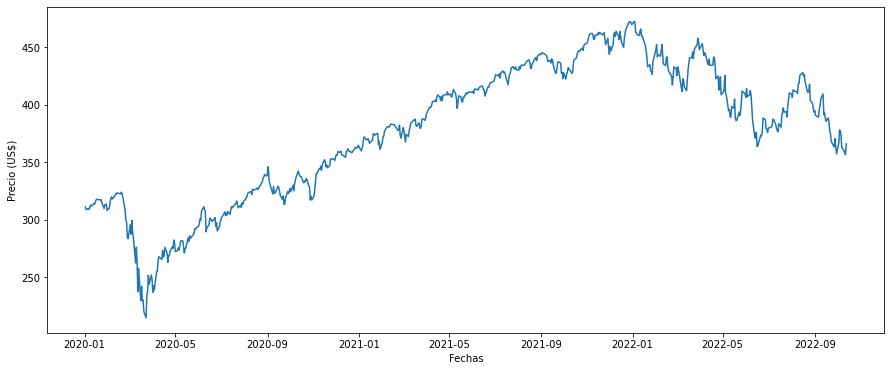

In [7]:
plt.figure(figsize=(15,6))
plt.plot(sp500)
plt.ylabel('Precio (US$)')
plt.xlabel('Fechas')
plt.show()

In [8]:
#Funcion para automatizar la evaluacion de promedio moviles y valores atipicos
def GraficarPromedioMovil(df,ventana,intervalos=False,escala=2,anomalias=False):
    
    promedio_movil = df.rolling(window=ventana).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Promedio movil\n ventana = {}".format(ventana))
    plt.plot(promedio_movil,"g",label="Tendencia de Promedio Movil")
    
    if intervalos:
        error_absoluto_medio = mean_absolute_error(df[ventana:],df.rolling(window=ventana).mean()[ventana:])
        desviacion_error = np.std(df[ventana:] - df.rolling(window=ventana).mean()[ventana:])
        banda_inferior = df.rolling(window=ventana).mean()[ventana:] - (error_absoluto_medio + escala*desviacion_error)
        banda_superior = df.rolling(window=ventana).mean()[ventana:] + (error_absoluto_medio + escala*desviacion_error)
        plt.plot(banda_superior,"r--", label="Banda Superior /Banda Inferior")
        plt.plot(banda_inferior,"r--")
        
    if anomalias:
        anomalias = pd.DataFrame(index=df.index, columns=df.columns)
        anomalias[df[ventana:]<banda_inferior] = df[ventana:][df[ventana:]<banda_inferior]
        anomalias[df[ventana:]>banda_superior] = df[ventana:][df[ventana:]>banda_superior]
        plt.plot(anomalias,"ro",markersize=10)
        
    plt.plot(df[ventana:], label="Valores reales")
    plt.legend(loc="upper left")
    plt.grid(True)

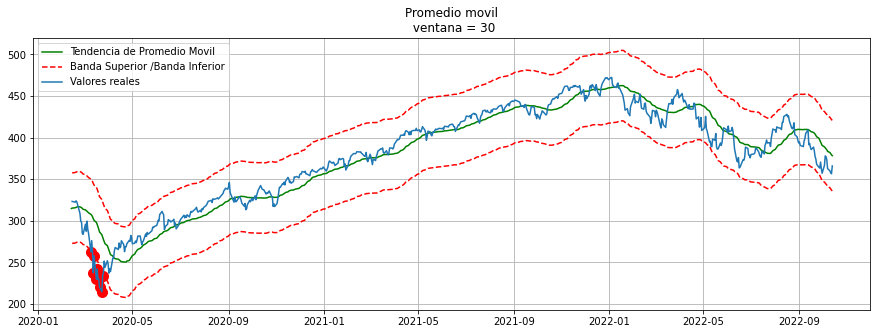

In [9]:
GraficarPromedioMovil(sp500, 30, intervalos=True, escala=2,anomalias=True)

# Descomposición de una Serie de Tiempo

**- Tendencia:** calcula usando un promedio móvil centrado de la serie de tiempo. La media móvil se calcula utilizando una longitud de ventana correspondiente a la frecuencia de la serie temporal. Por ejemplo, usaríamos una ventana de longitud 12 para datos mensuales, en el caso de nosotros los datos son diarios y utilizaremos una ventana de 1 año por lo cual, sería 365.

**- Estacionalidad:** Para calcular el componente estacional, primero debemos eliminar la tendencia de la serie temporal. Lo hacemos restando el componente de tendencia de la serie de tiempo original.

Una vez hecho esto, calculamos los valores promedio de la serie sin tendencia para cada período estacional. En el caso de los meses, calcularíamos el valor sin tendencia promedio para cada mes.

El componente estacional simplemente se construye a partir de los promedios estacionales repetidos a lo largo de toda la serie Nuevamente, este es uno de los argumentos en contra del uso de la descomposición estacional simple: no se permite que el componente estacional cambie con el tiempo, lo que puede ser una medida muy estricta, ademas de una suposición poco realista para series de tiempo largas.

**- Residuos:** El último componente es simplemente lo que queda después de eliminar (restando o dividiendo) los componentes de tendencia y estacionales de la serie de tiempo original.


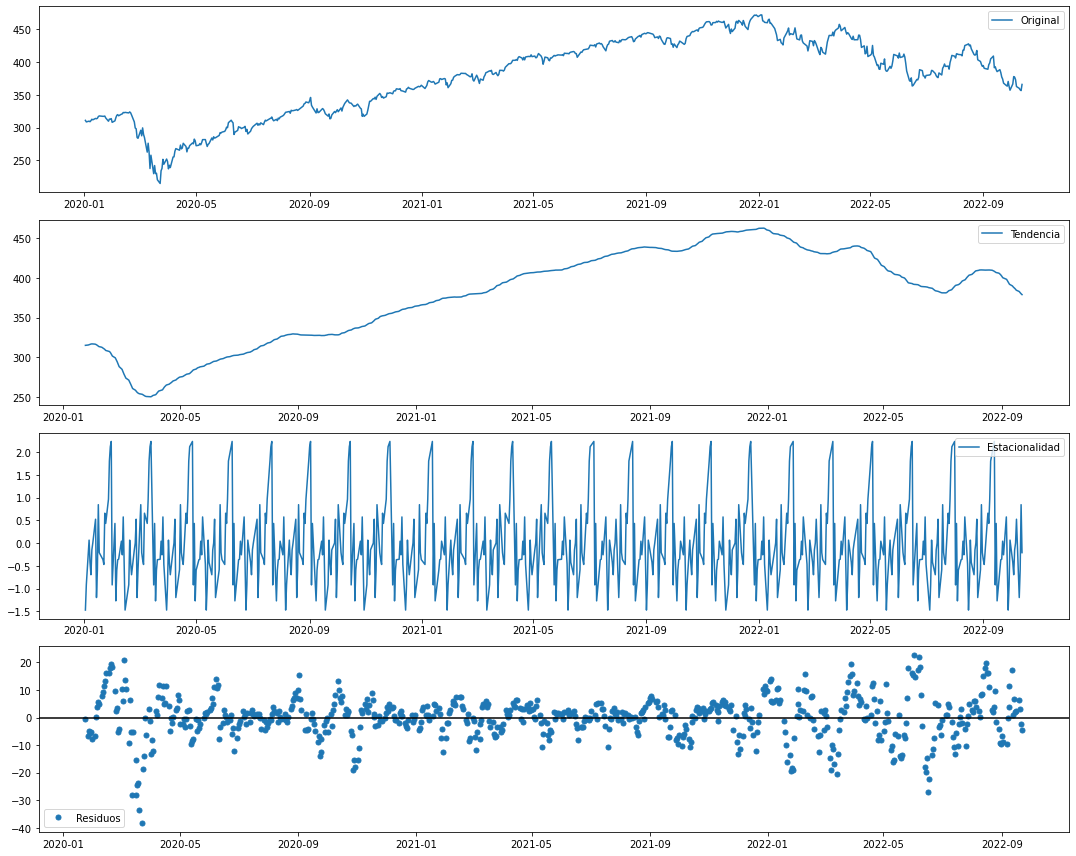

In [10]:
descomposicion = seasonal_decompose(sp500,period = 30)

tendencia = descomposicion.trend
estacionalidad = descomposicion.seasonal
residuos = descomposicion.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(sp500, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(estacionalidad,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos',marker='o', linestyle = 'None', markersize = 5)
plt.axhline(color='black')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<AxesSubplot:>

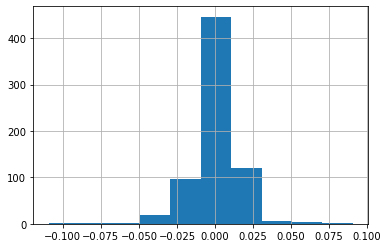

In [11]:
sp500['Adj Close'].pct_change().hist()

In [12]:
sp500['Rendimiento'] = sp500.apply(np.log).diff(1) 

In [13]:
dias = 60
simulaciones = 10000
volatilidad = sp500['Rendimiento'].std()
retornos = sp500['Rendimiento'].mean()

In [14]:
# CREA UNA LISTA VACIA PARA AGREGAR LAS FECHAS
fechas = []

# CON UN FOR LOOP LLENA LA LISTA CON LA CANTIDAD DE DIAS RESTANTES HASTA FINAL DE AÑO
for i in range(dias):
    dia = sp500.index.max()+pd.DateOffset(i)
    fechas.append([dia])

In [15]:
# CONVIERTE LA LISTA DE FECHAS EN UN DATAFRAME
df_cambios = pd.DataFrame(fechas, columns=['Date'])

In [16]:
#lista vacia para agregar los precios aleatorios
precio_lista = [] 

#cantidad de escenarios
escenarios = 101 

#dataframe solo con las fechas a proyectar
escenarios_df = df_cambios[['Date']] 

#para cada escenario
for escenario in list(range(escenarios)): 
    
    #asigna nombre de columna basado en el escenario con los valores de los precios
    escenarios_df['escenario_{}'.format(escenario)] = pd.Series(precio_lista)
    
    #vaciamos los precios de lista para poner el nuevo dia con los precios aleatorios
    precio_lista.clear() 
    
    #agrega el precio inicial a lista de precios para asignarle las ganancias aleatorias
    precio_lista.append(float(sp500[sp500.index == sp500.index.max()]['Adj Close']))        
    
    #para cada dia de cada escenario
    for dia in range(1,dias):
        
        #creamos las simulaciones con la misma media y desviación estándar
        cambios = np.random.normal(retornos, volatilidad, simulaciones)
        
        #el precio es el ultimo precio de la lista de precios multiplicado por un porcentaje de ganancia aleatorio de la lista de ganancias aletorias generadas
        precio =  precio_lista[-1] * (1+random.choice(cambios))
        
        #agregamos el precio a la lista de precios
        precio_lista.append(precio)

C:\Users\galmonte\AppData\Local\Temp/ipykernel_21364/1064557651.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  escenarios_df['escenario_{}'.format(escenario)] = pd.Series(precio_lista)
C:\Users\galmonte\AppData\Local\Temp/ipykernel_21364/1064557651.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  escenarios_df['escenario_{}'.format(escenario)] = pd.Series(precio_lista)


In [17]:
# CREA DATAFRAME CON 100 ESCENARIOS DE LA EVOLUCION DE LOS PRECIOS DEL GAS NATURAL DE MANERA ALEATORIA
escenarios_df.drop('escenario_0', axis=1,inplace=True)

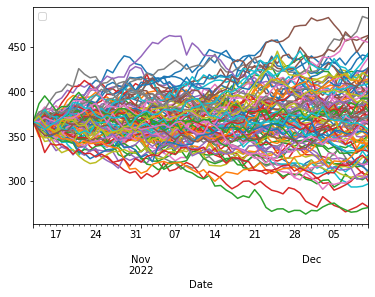

In [18]:
# GRAFICA LOS ESCENARIOS
escenarios_df.plot(x='Date')
plt.legend('')

In [19]:
escenarios_df['perc_05'] = escenarios_df.quantile(0.05,axis=1,numeric_only=True)
escenarios_df['perc_15'] = escenarios_df.quantile(0.15,axis=1,numeric_only=True)
escenarios_df['perc_25'] = escenarios_df.quantile(0.25,axis=1,numeric_only=True)
escenarios_df['perc_50'] = escenarios_df.quantile(0.50,axis=1,numeric_only=True)
escenarios_df['perc_75'] = escenarios_df.quantile(0.75,axis=1,numeric_only=True)
escenarios_df['perc_95'] = escenarios_df.quantile(0.95,axis=1,numeric_only=True)

In [20]:
escenarios_df.set_index('Date', inplace=True)

In [21]:
escenarios_df.head()

,escenario_1,escenario_2,escenario_3,escenario_4,escenario_5,escenario_6,escenario_7,escenario_8,escenario_9,escenario_10,...,escenario_97,escenario_98,escenario_99,escenario_100,perc_05,perc_15,perc_25,perc_50,perc_75,perc_95
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-13,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,...,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000,365.970000
2022-10-14,365.679140,371.475597,362.981048,376.530370,364.184228,368.109379,366.908327,354.095253,368.697076,373.490392,...,365.960329,373.596871,372.372673,363.675625,354.091232,358.217702,360.833418,366.314888,369.576711,375.977985
2022-10-15,371.166338,370.033573,359.326219,375.019379,360.368735,363.786704,366.845493,360.884664,366.469650,377.133759,...,370.627121,376.621355,363.431233,357.326720,351.924173,356.941557,359.135043,363.538702,369.697292,379.404975
2022-10-16,368.181461,363.994794,361.199246,370.926124,359.776832,360.437316,371.893938,363.147396,365.584472,374.178056,...,367.941729,371.540117,357.761645,362.020560,348.639065,354.032343,357.235101,363.032394,370.057933,378.174419
2022-10-17,370.591308,371.136721,363.462481,365.583454,361.707765,360.889850,376.044962,358.251571,373.433320,357.269109,...,365.842331,377.764216,355.102454,365.867100,346.405579,352.994441,355.220056,363.840879,369.300323,377.532020


No handles with labels found to put in legend.


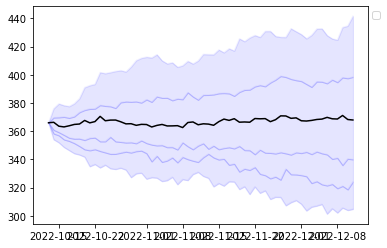

In [22]:
#graficamos los escenarios.
plt.plot(escenarios_df[['perc_05','perc_15','perc_25','perc_75','perc_95']],color='blue',alpha=0.05)
plt.plot(escenarios_df[['perc_50']],color='black')
plt.fill_between(escenarios_df.index,escenarios_df['perc_05'],escenarios_df['perc_15'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_15'],escenarios_df['perc_25'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_25'],escenarios_df['perc_75'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_75'],escenarios_df['perc_95'],color='blue',alpha=0.1)
plt.legend(bbox_to_anchor=(1.05,1))

In [23]:
#unificando dataframes de simulaciones con datos reales
df_concat = pd.concat([sp500.reset_index(),escenarios_df.reset_index()], axis=0) 
df_concat.reset_index(drop=True, inplace=True)
#eliminando columna innecesaria
df_concat.drop('Rendimiento', axis='columns', inplace=True)
df_concat.head()

,Date,Adj Close,escenario_1,escenario_2,escenario_3,escenario_4,escenario_5,escenario_6,escenario_7,escenario_8,...,escenario_97,escenario_98,escenario_99,escenario_100,perc_05,perc_15,perc_25,perc_50,perc_75,perc_95
0,2020-01-02,311.116974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,308.761230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,309.939148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,309.067627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-08,310.714844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_concat.set_index('Date',inplace=True)

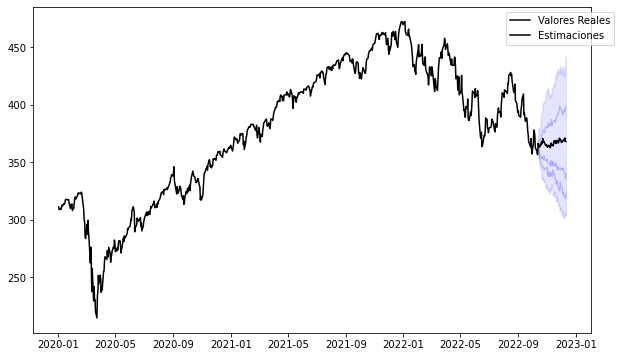

In [25]:
plt.figure(figsize=(10,6))
plt.plot(df_concat[['Adj Close']],color='black',label='Valores Reales')
plt.plot(df_concat[['perc_05','perc_15','perc_25','perc_75','perc_95']],color='blue',alpha=0.05)
plt.plot(df_concat[['perc_50']],color='black', label='Estimaciones')
plt.fill_between(df_concat.index,df_concat['perc_05'],df_concat['perc_15'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_15'],df_concat['perc_25'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_25'],df_concat['perc_75'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_75'],df_concat['perc_95'],color='blue',alpha=0.1)
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

In [26]:
df_descripciones_escenarios = escenarios_df.describe()[1:].transpose()

In [27]:
print("Resultados del escenario simulado con tendencia más alcista:")
print('Último precio registrado: {:,.2f}'.format(float(sp500[sp500.index == sp500.index.max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].max(),2)))

Resultados del escenario simulado con tendencia más alcista:
Último precio registrado: 365.97
mean: 421.89
std: 37.94
min: 365.97
25%: 416.6
50%: 429.94
75%: 456.57
max: 483.74


In [28]:
print("Resultados del escenario simulado con tendencia más bajista:")
print('Último precio registrado: {:,.2f}'.format(float(sp500[sp500.index == sp500.index.max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].min(),2)))

Resultados del escenario simulado con tendencia más bajista:
Último precio registrado: 365.97
mean: 307.39
std: 2.18
min: 262.69
25%: 270.39
50%: 305.16
75%: 320.47
max: 365.97


In [29]:
print("Resultados del escenario más probable todos los escenarios simulados:")
print('Último precio registrado: {:,.2f}'.format(float(sp500[sp500.index == sp500.index.max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].mean(),2)))

Resultados del escenario más probable todos los escenarios simulados:
Último precio registrado: 365.97
mean: 367.81
std: 16.2
min: 337.35
25%: 355.37
50%: 367.97
75%: 380.12
max: 399.96
